# LG3 MLP baseline demo

MLP baseline using 2 days input (Tin=576) to predict 1 day (Tout=288) from preprocessed data.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- config ---
DATA_DIR1 = os.path.abspath(os.path.join('..', 'data', 'processed_sources', 'elec1_f2'))
DATA_DIR2 = os.path.abspath(os.path.join('..', 'data', 'processed_sources', 'snu'))
DATA_DIR3 = os.path.abspath(os.path.join('..', 'data', 'processed_sources', 'ohsung_f2'))
TIN = 576  # 2 days at 5-min
TOUT = 288  # 1 day at 5-min
TARGET_COL = 'Power'
EPOCHS = 150
LR = 1e-3
BATCH_SIZE = 4096


In [27]:
def load_split(split, data_dir):
    path = os.path.join(data_dir, f'lg3_{split}.csv')
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    df = df.select_dtypes(include=[np.number]).dropna(how='any')
    return df

def build_sequences(values, seq_len, pred_len):
    total = len(values)
    max_start = total - (seq_len + pred_len) + 1
    if max_start <= 0:
        raise ValueError('Not enough rows to build sequences.')
    x = np.empty((max_start, seq_len, values.shape[1]), dtype=np.float32)
    y = np.empty((max_start, pred_len), dtype=np.float32)
    for i in range(max_start):
        x[i] = values[i : i + seq_len]
        y[i] = values[i + seq_len : i + seq_len + pred_len, 0]
    return x, y

train_df = load_split('train', DATA_DIR1)
val_df = load_split('val', DATA_DIR1)
test_df = load_split('test', DATA_DIR2)

if TARGET_COL not in train_df.columns:
    raise ValueError(f'{TARGET_COL} not in data columns')

# put target column first for convenience
cols = [TARGET_COL] + [c for c in train_df.columns if c != TARGET_COL]
train_df = train_df[cols]
val_df = val_df[cols]
test_df = test_df[cols]

X_train, y_train = build_sequences(train_df.to_numpy(np.float32), TIN, TOUT)
X_val, y_val = build_sequences(val_df.to_numpy(np.float32), TIN, TOUT)
X_test, y_test = build_sequences(test_df.to_numpy(np.float32), TIN, TOUT)

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)


X_train (10157, 576, 2) y_train (10157, 288)
X_val (711, 576, 2) y_val (711, 288)
X_test (4377, 576, 2) y_test (4377, 288)


In [28]:
# standardize inputs using train stats
feat_mean = X_train.mean(axis=(0, 1), keepdims=True)
feat_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_n = (X_train - feat_mean) / feat_std
X_val_n = (X_val - feat_mean) / feat_std
X_test_n = (X_test - feat_mean) / feat_std

# target normalization (Power)
y_mean = y_train.mean()
y_std = y_train.std() + 1e-6
y_train_n = (y_train - y_mean) / y_std
y_val_n = (y_val - y_mean) / y_std
y_test_n = (y_test - y_mean) / y_std


In [4]:
class MLPBaseline(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, out_dim),
        )

    def forward(self, x):
        return self.net(x)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
in_dim = X_train_n.shape[1] * X_train_n.shape[2]
out_dim = TOUT
model = MLPBaseline(in_dim, out_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

def make_loader(X, y):
    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float()
    ds = torch.utils.data.TensorDataset(X_t, y_t)
    return torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

train_loader = make_loader(X_train_n, y_train_n)
val_loader = make_loader(X_val_n, y_val_n)

for epoch in range(EPOCHS):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device).view(xb.size(0), -1)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item()
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            vb_total = 0.0
            for xb, yb in val_loader:
                xb = xb.to(device).view(xb.size(0), -1)
                yb = yb.to(device)
                pred = model(xb)
                vb_total += loss_fn(pred, yb).item()
        print(f'epoch {epoch+1} | train mse {total/len(train_loader):.6f} | val mse {vb_total/len(val_loader):.6f}')


epoch 5 | train mse 0.567143 | val mse 0.357442
epoch 10 | train mse 0.423780 | val mse 0.398576
epoch 15 | train mse 0.308885 | val mse 0.483383
epoch 20 | train mse 0.252861 | val mse 0.586839
epoch 25 | train mse 0.223155 | val mse 0.601969
epoch 30 | train mse 0.205274 | val mse 0.642187
epoch 35 | train mse 0.188133 | val mse 0.655185
epoch 40 | train mse 0.173307 | val mse 0.666264
epoch 45 | train mse 0.161972 | val mse 0.666351
epoch 50 | train mse 0.147951 | val mse 0.685348
epoch 55 | train mse 0.138133 | val mse 0.690111
epoch 60 | train mse 0.136277 | val mse 0.677605
epoch 65 | train mse 0.123340 | val mse 0.685184
epoch 70 | train mse 0.115989 | val mse 0.701345
epoch 75 | train mse 0.109393 | val mse 0.696487
epoch 80 | train mse 0.109135 | val mse 0.677746
epoch 85 | train mse 0.102504 | val mse 0.709329
epoch 90 | train mse 0.097305 | val mse 0.722725
epoch 95 | train mse 0.093014 | val mse 0.721388
epoch 100 | train mse 0.091422 | val mse 0.727824
epoch 105 | train ms

In [29]:
model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_n).float().to(device).view(X_test_n.shape[0], -1)
    pred_n = model(X_test_t).cpu().numpy()

pred = pred_n * y_std + y_mean
mse = np.mean((y_test - pred) ** 2)
mae = np.mean(np.abs(y_test - pred))
print(f'Test MSE: {mse:.6f} | MAE: {mae:.6f}')


Test MSE: 3.339468 | MAE: 1.366422


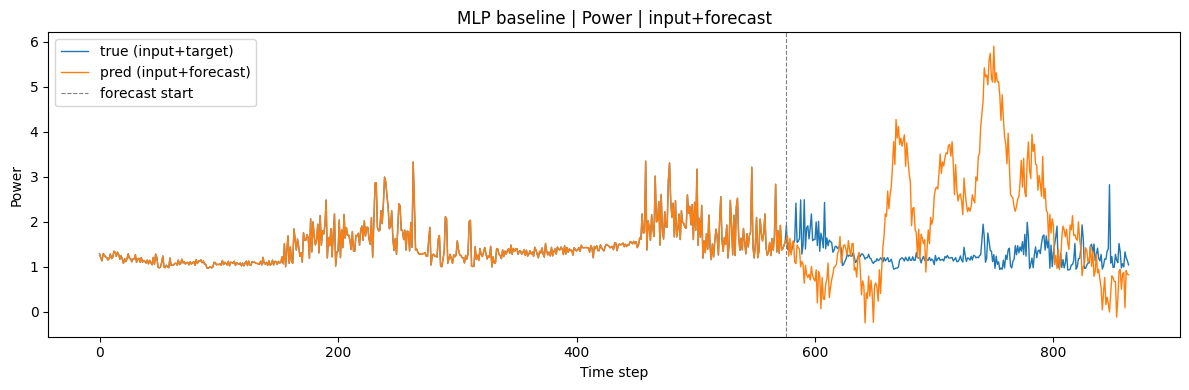

In [32]:
# plot one example with input context
ratio = 0.2
idx = int(ratio * X_test.shape[0]) - 1
inp = X_test[idx, :, 0]  # Power channel (target is first column)
true = y_test[idx]
pred_y = pred[idx]

full_x = np.concatenate([inp, true])
full_pred = np.concatenate([inp, pred_y])

plt.figure(figsize=(12, 4))
plt.plot(full_x, label='true (input+target)', linewidth=1.0)
plt.plot(full_pred, label='pred (input+forecast)', linewidth=1.0)
plt.axvline(x=TIN, color='gray', linestyle='--', linewidth=0.8, label='forecast start')
plt.title(f'MLP baseline | {TARGET_COL} | input+forecast')
plt.xlabel('Time step')
plt.ylabel(TARGET_COL)
plt.legend()
plt.tight_layout()
plt.show()
